# EDA Project 2 - 
_______

### Data Description
These data provide a window into how people are interacting with the government online. The data come from a unified Google Analytics account for U.S. federal government agencies known as the Digital Analytics Program. This program helps government agencies understand how people find, access, and use government services online. The program does not track individuals, and anonymizes the IP addresses of visitors.

Not every government website is represented in these data. Currently, the Digital Analytics Program collects web traffic from around 400 executive branch government domains, across about 5,700 total websites, including every cabinet department. We continue to pursue and add more sites frequently; to add your site, email the Digital Analytics Program.

## Question and Problem Definition

## Workflow Goals

### Import Libraries

In [1]:
from collections.abc import Sequence
import datetime
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

import pyarrow.parquet as pq
from tqdm import tqdm

%matplotlib inline

### Data Acquisition
**Background**

One of the challenges of this project was acquiring data.  The original dataset we prospected was found to be corrupted. 
After looking at the data, we found that the there were so many errors, it would have been nearly impossible to complete the project as planned.

**Error Source** 

The data was corrupted by human error.  The developers who maintain the dataset, allowed synthetic data to contaminate the downloadable `.csv` files they make available to the public.  Over half of the observations contained website domains such as www.fakesite.com.  

**Solution**

Instead of waiting for the data errors to be fixed and run the risk of having incomplete data for our project, we decided to proceed with acquiring data through the API.  We did need to adjust our initial data questions as the API is still in BETA and did not have the same headers available as the `.csv` files.  Where we did lose some variable information, we did gain the ability to acquire time-series data, which was not available in the original dataset.  

The analytics.usa.gov has made the following datasets available for download:
- Download: Refers to the number of times a file or asset has been downloaded from a website.
- Traffic-source: Refers to the channel or medium that a visitor used to reach a website, such as organic search, social media, or paid advertising.
- Device-model: Refers to the specific model of device that a visitor used to access a website, such as an iPhone X or Samsung Galaxy S21.
- Domain: Refers to the main domain name of a website, such as example.com.
- Site: Refers to a specific subdomain or section of a website, such as blog.example.com.
- Second-level-domain: Refers to the part of a domain name that comes before the top-level domain (TLD), such as example in example.com.
- Language: Refers to the primary language of a website or the language preference of a visitor's browser.
- OS-browser: Refers to the combination of operating system and web browser used by a visitor to access a website, such as Windows 10 and Chrome.
- Windows-browser: Refers specifically to web browsers running on the Windows operating system, such as Internet Explorer or Microsoft Edge.
- Browser: Refers to the specific web browser used by a visitor to access a website, such as Chrome, Firefox, or Safari.
- Windows-ie: Refers specifically to the Internet Explorer web browser running on the Windows operating system.
- OS: Refers to the specific operating system used by a visitor to access a website, such as Windows, macOS, iOS, or Android.
- Windows: Refers specifically to the Windows operating system.
- IE: Refers specifically to the Internet Explorer web browser.

#### Reports we are analyzing	

Domain_report_all_agencies.parquet
Contains daily visits per domain for all participating agencies
Example
Download_report_all_agencies.parquet
Daily # of file downloads (include page and file title) from agencies sites
Example
Language_report_all_agencies.parquet
Daily visits per language to each agency sites
Example
Second-level-domain_report_all_agencies.parquet
Is not clear what is the difference between this and the domain report
Should we drop it? 
Example
Site_report_all_agencies.parquet
Is not clear what is the difference between this and the domain report
Should we drop it?
Example
Traffic-source_report_all_agencies.parquet
Daily visits to agencies sites broken down by source domain
Example



#### Agencies in scope
‘health-human-services', 
'postal-service', 
'social-security-administration',
'treasury'

In [40]:
def api_to_parquet(agencies: Sequence[str], reports: Sequence[str], api_key: str, response_limit=1000) -> None:
    """Function to make API calls to the DAP API and write the data to a parquet file.

    Args:
        agencies (Sequence[str]): List of agencies to pull data for.
        reports (Sequence[str]): List of reports to pull data for.
        api_key (str): API key for the DAP API.
        response_limit (int, optional): Sets a limit on the number of responses. Defaults to 1000.
    """
    start_date = datetime.datetime.strptime('2020-03-01', '%Y-%m-%d')
    end_date = datetime.datetime.strptime('2020-03-31', '%Y-%m-%d')
    increment_days = 30
    
    num_periods = ((datetime.datetime.now() - start_date).days + 1) // increment_days
    
    # Loop through the reports.
    for report in reports:
        new_dataframe = pd.DataFrame()
        # Loop through the agencies.
        for agency in agencies:
            print(f"I'm on {report}/{agency}")
            # Create the URL for the API call.
            url = f"https://api.gsa.gov/analytics/dap/v1.1/agencies/{agency}/reports/{report}/data?api_key={api_key}"
            with tqdm(total=num_periods) as pbar:
                # Loop through the date range.
                while start_date < datetime.datetime.now():
                    
                    # Add the date range parameters to the URL and increment the dates by 1 day.
                    url_date_params = f"&after={start_date.strftime('%Y-%m-%d')}&before={end_date.strftime('%Y-%m-%d')}&limit={response_limit}"
                    full_url = url + url_date_params

                    response = requests.get(full_url).json() # api call
                    response = pd.DataFrame(response) # make the json response a dataframe.

                    # Concatenate the new data to the existing dataframe.
                    new_dataframe = pd.concat([new_dataframe, response])
                    
                    # Increment the dates by the specified number of days.
                    start_date += datetime.timedelta(days=increment_days)
                    end_date += datetime.timedelta(days=increment_days)
                    
                    # Update progress bar.
                    pbar.update(1)
            start_date = datetime.datetime.strptime('2020-01-01', '%Y-%m-%d')
            end_date = datetime.datetime.strptime('2020-03-31', '%Y-%m-%d')
            
            print(full_url)            
        new_dataframe['date'] = pd.to_datetime(new_dataframe['date'])

        # write to parquet file to the data folder.
        new_dataframe.to_parquet(f"./data/2{report}_report_all_agencies.parquet")


In [53]:

list_of_agencies = [
    # 'health-human-services', 
    # 'postal-service', 
    'social-security-administration',
    # 'treasury',
    ]
list_of_reports = ['second-level-domain']

# api key 
api_key = 'your_api_key'

# call the function
api_to_parquet(list_of_agencies, list_of_reports, api_key, response_limit=1000)


I'm on second-level-domain/social-security-administration


39it [09:00, 13.86s/it]                        

https://api.gsa.gov/analytics/dap/v1.1/agencies/social-security-administration/reports/second-level-domain/data?api_key=Yzfx1geHF5I1Ht60pyEJhhdrkCtFvYBhk25wORIH&after=2023-04-15&before=2023-05-15&limit=1000


### Load Dataset
(observations & notes)

In [3]:
df_sites = pd.read_parquet('./data/site_report_all_agencies.parquet')
df_sites.head()


,id,date,report_name,report_agency,domain,visits
0,62048352,2020-03-31,site,health-human-services,cdc.gov,12248683
1,62048353,2020-03-31,site,health-human-services,ncbi.nlm.nih.gov,6300062
2,62048354,2020-03-31,site,health-human-services,medlineplus.gov,2033758
3,62048355,2020-03-31,site,health-human-services,pubmed.ncbi.nlm.nih.gov,1287141
4,62048356,2020-03-31,site,health-human-services,fda.gov,785867


In [33]:
df_language = pd.read_parquet('./data/language_report_all_agencies.parquet')
df_language.head()

,id,date,report_name,report_agency,visits,language
0,62039536,2020-03-31,language,health-human-services,19436137,en-us
1,62039537,2020-03-31,language,health-human-services,1526721,en-gb
2,62039538,2020-03-31,language,health-human-services,966842,es-es
3,62039539,2020-03-31,language,health-human-services,614554,es-419
4,62039540,2020-03-31,language,health-human-services,539171,zh-cn


In [11]:
df_downloads = pd.read_parquet('./data/download_report_all_agencies.parquet')
df_downloads.head()

,id,date,report_name,report_agency,page,page_title,event_label,total_events
0,62032239,2020-03-31,download,energy,energy.gov/fe/downloads/lng-monthly-2020,LNG Monthly 2020 | Department of Energy,https://www.energy.gov/sites/prod/files/2020/0...,713
1,62032242,2020-03-31,download,energy,energy.gov/eere/fuelcells/downloads/fuel-cell-...,Fuel Cell Technologies Office Multi-Year Resea...,https://www.energy.gov/sites/prod/files/2015/0...,476
2,62032243,2020-03-31,download,energy,energy.gov/management/downloads/pf-2020-20-cov...,PF 2020-20 COVID-19 Guidance for Financial Ass...,https://www.energy.gov/sites/prod/files/2020/0...,384
3,62032244,2020-03-31,download,energy,energy.gov/cio/office-chief-information-office...,Virtual Desktop Infrastructure (VDI) and Citri...,https://www.energy.gov/sites/prod/files/2019/0...,386
4,62032271,2020-03-31,download,energy,energy.gov/hc/about-us,About Us | Department of Energy,https://www.energy.gov/sites/prod/files/2019/0...,193


In [14]:
df_domains = pd.read_parquet('./data/domain_report_all_agencies.parquet')
df_domains.head()

,id,date,report_name,report_agency,domain,visits
0,62032080,2020-03-31,domain,energy,energy.gov,96664
1,62032081,2020-03-31,domain,energy,osti.gov,12539
2,62032082,2020-03-31,domain,energy,afdc.energy.gov,7639
3,62032083,2020-03-31,domain,energy,sandia.gov,1642
4,62032084,2020-03-31,domain,energy,swpa.gov,1403


In [28]:
df_traffic_source = pd.read_parquet('./data/traffic-source_report_all_agencies.parquet')
df_traffic_source.head()

,id,date,report_name,report_agency,source,visits,has_social_referral
0,62042829,2020-03-31,traffic-source,health-human-services,google,17009249,No
1,62042830,2020-03-31,traffic-source,health-human-services,(direct),4042668,No
2,62042831,2020-03-31,traffic-source,health-human-services,bing,615788,No
3,62042832,2020-03-31,traffic-source,health-human-services,youtube.com,645586,Yes
4,62042833,2020-03-31,traffic-source,health-human-services,cdc.gov,463127,No


### View and Describe Data
(observations & notes)

In [4]:
df_sites.groupby('report_agency')['visits'].sum().sort_values(ascending=False)

report_agency
postal-service                    52698630621
treasury                          20893372058
health-human-services             19199126546
social-security-administration     3595729500
Name: visits, dtype: int64

In [29]:
df_traffic_source.groupby('source')['visits'].sum().sort_values(ascending=False).head(20)

source
google                       1007093944
(direct)                      479199136
irs.gov                       116813670
reg.usps.com                  112277781
usps.com                       82852147
bing                           60007849
sa.www4.irs.gov                41929448
informeddelivery.usps.com      40009972
ssa.gov                        34608887
secure.ssa.gov                 29732427
pubmed.ncbi.nlm.nih.gov        28516330
tools.usps.com                 19866019
govdelivery                    16958616
yahoo                          15847819
secure.login.gov               13464243
m.facebook.com                 11701368
expected                       10802440
ncbi.nlm.nih.gov               10720673
search.ssa.gov                 10379316
faq.ssa.gov                     8977171
Name: visits, dtype: int64

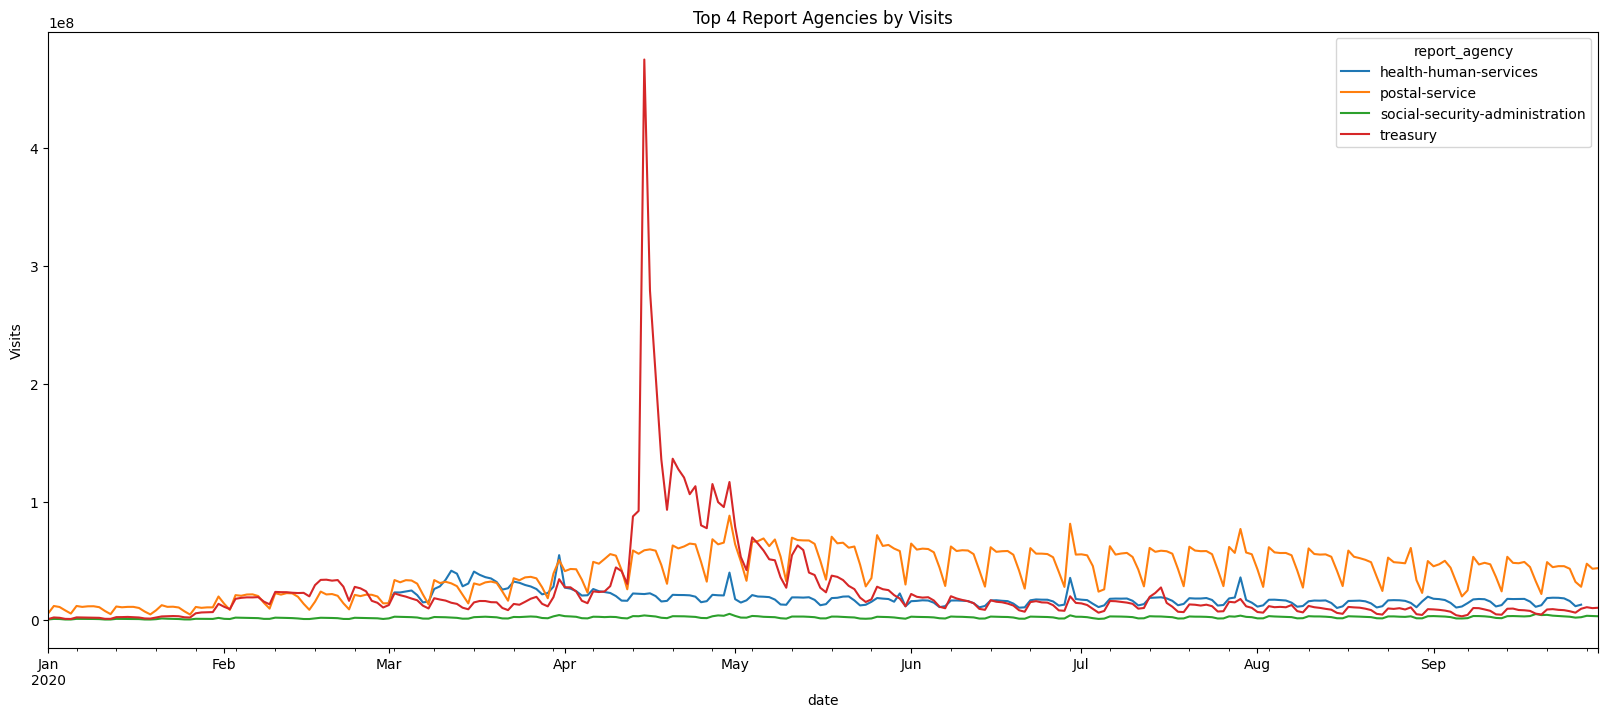

In [52]:
fig, ax = plt.subplots(figsize=(20, 8))

df_grouped = df_sites.groupby(['date', 'report_agency']).agg({'visits': 'sum'})
top_agencies = df_grouped.groupby('report_agency').agg({'visits': 'sum'}).nlargest(5, 'visits').index

df_filtered = df_grouped[df_grouped.index.get_level_values('report_agency').isin(top_agencies)]
df_pivot = df_filtered.pivot_table(index='date', columns='report_agency', values='visits')

df_pivot = df_pivot.loc['2020-01': '2020-09']

df_pivot.plot.line(ax=ax)

plt.ylabel('Visits')
plt.title('Top 4 Report Agencies by Visits')
plt.show()

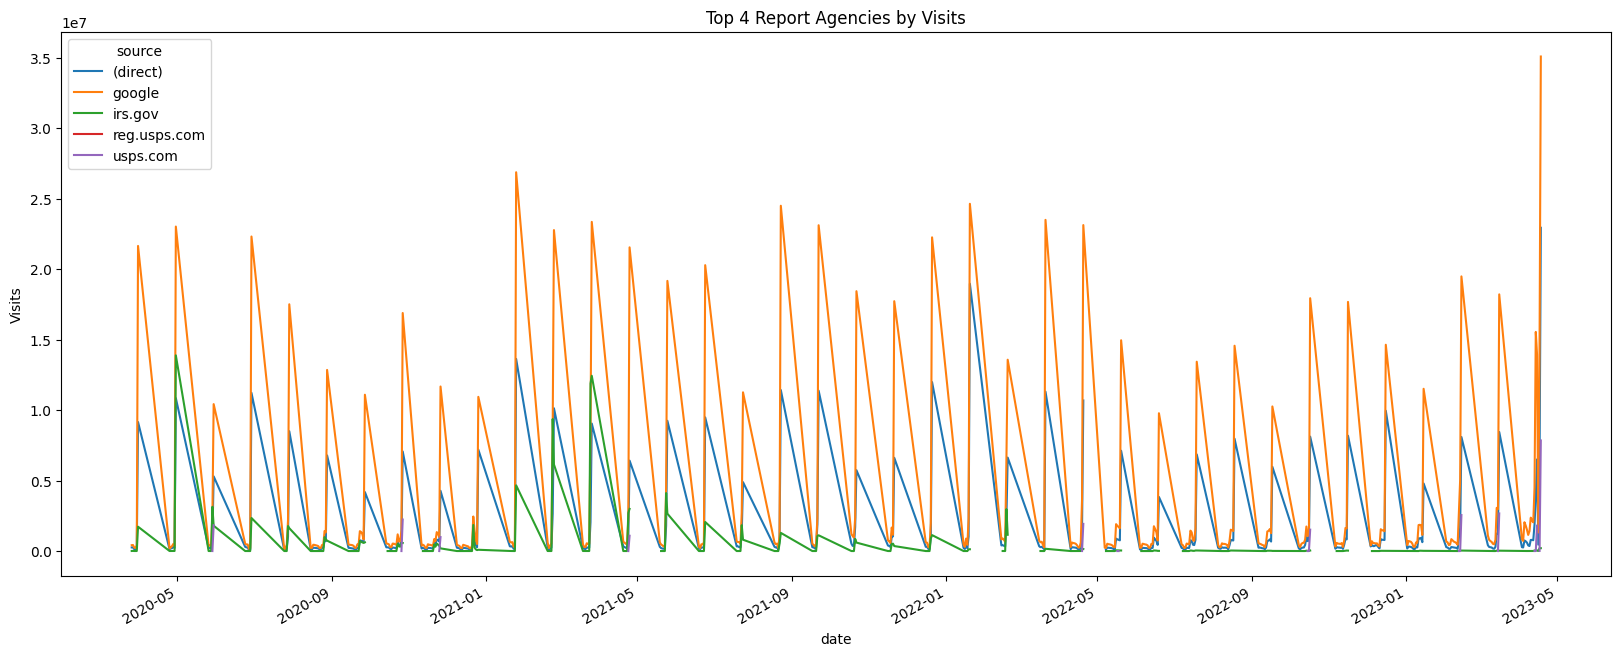

In [32]:
fig, ax = plt.subplots(figsize=(20, 8))

df_grouped = df_traffic_source.groupby(['date', 'source']).agg({'visits': 'sum'})
top_agencies = df_grouped.groupby('source').agg({'visits': 'sum'}).nlargest(5, 'visits').index

df_filtered = df_grouped[df_grouped.index.get_level_values('source').isin(top_agencies)]
df_pivot = df_filtered.pivot_table(index='date', columns='source', values='visits')

df_pivot.plot.line(ax=ax)

plt.ylabel('Visits')
plt.title('Top 4 Report Agencies by Visits')
plt.show()